In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import PIL
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import librosa

from PIL import Image

In [2]:
ACTIONS = [['LEFT'], ['RIGHT'], ['LEFT', 'DOWN'], ['RIGHT', 'DOWN'], ['DOWN'],
           ['DOWN', 'B'], ['B']]

In [3]:
from scipy.io.wavfile import read
import numpy as np
import librosa
import librosa.display
sr, a = read("/tmp/temp.wav")
a = a / 2.0**15
print(a[:20])
print(a.dtype)
print(a.shape)

# aud = Audio("/tmp/temp.wav")
# display(aud)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.05175781e-05
  1.83105469e-04  0.00000000e+00  8.54492188e-04  5.18798828e-04
  7.69042969e-03  2.83203125e-02  4.66308594e-02  6.28051758e-02
  7.83386230e-02  9.10339355e-02  1.00555420e-01  1.05743408e-01
  1.06781006e-01  1.04217529e-01  9.80224609e-02  8.98742676e-02]
float64
(220500,)


(512, 862)


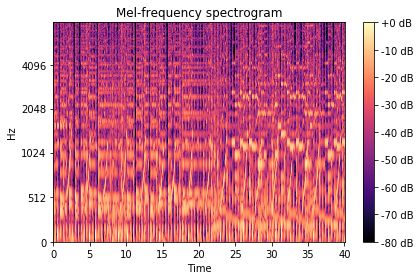

In [4]:
n_fft = 512
mels = librosa.feature.melspectrogram(y=a, sr=sr, n_mels=n_fft, win_length=n_fft//2, hop_length=n_fft//2)
mels_db = librosa.power_to_db(mels, ref=np.max)
print(mels_db.shape)
librosa.display.specshow(mels_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

(512, 3446) float32 -1.9073486e-06 -80.0


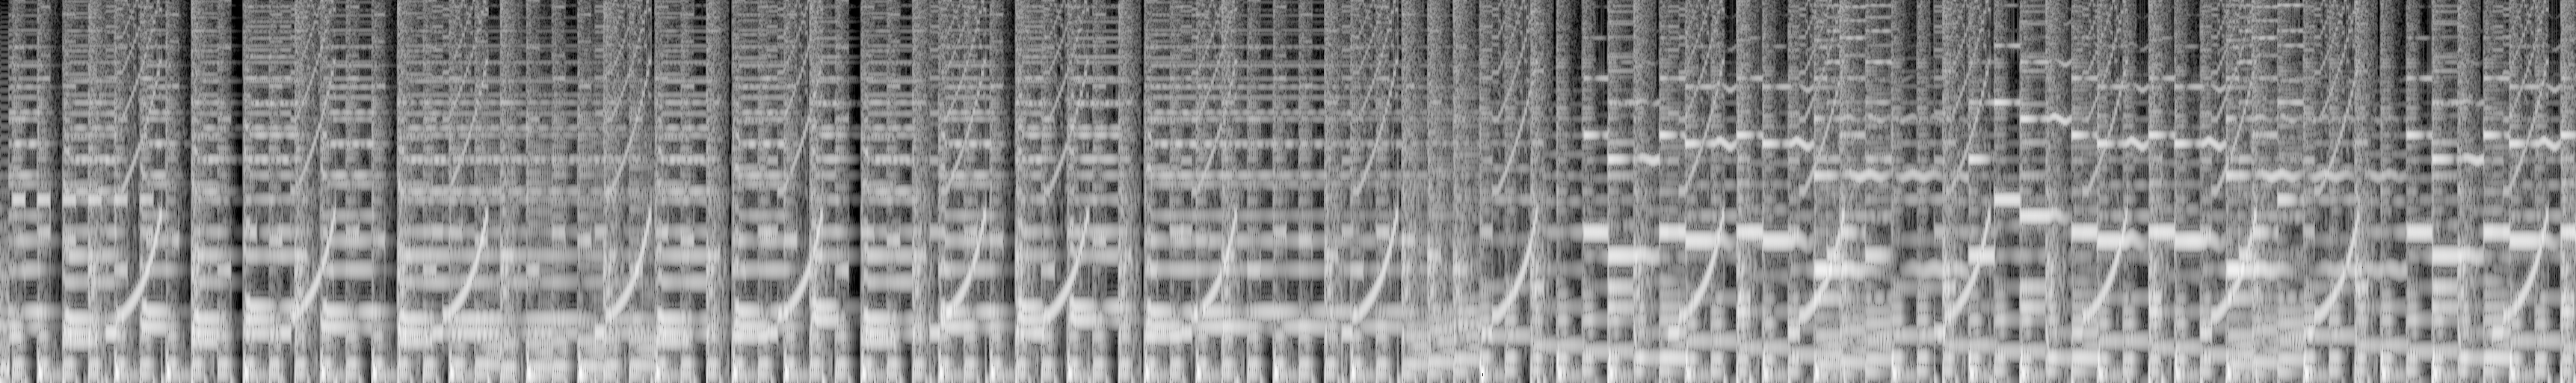

In [5]:
n_fft = 512
mels = librosa.feature.melspectrogram(y=a, sr=sr, n_fft=2048, n_mels=n_fft, win_length=n_fft//2, hop_length=n_fft//8)
mels_db = librosa.power_to_db(mels, ref=np.max)
print(mels_db.shape, mels_db.dtype, mels_db.max(), mels_db.min())
mels_db = np.uint8(mels_db/80*255)

aud_im = Image.fromarray(np.flip(mels_db, axis=0), 'L')
display(aud_im)

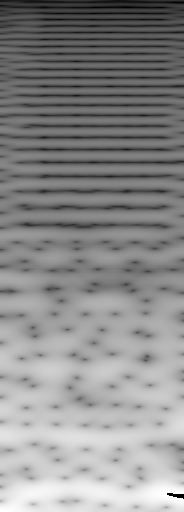

In [6]:
n_fft = 512
x = 735*0  # 14 is start of first jump
mels = librosa.feature.melspectrogram(y=a[x:x+735*1], sr=sr, n_mels=n_fft, win_length=n_fft//2, hop_length=n_fft//128)
mels_db = librosa.power_to_db(mels, ref=np.max)
mels_db = np.uint8(mels_db/80*255)

aud_im = Image.fromarray(np.flip(mels_db, axis=0), 'L')
display(aud_im)

In [7]:
from visualize.visualize import gen_eval_vid_frame
from a2c_ppo_acktr.envs import make_vec_envs


In [8]:
seed = 10
device = "cuda:0"
env_state = "GreenHillZone.Act1"
env = make_vec_envs(
    [env_state],
    seed + 1000,
    1,
    None,
    device=device,
    allow_early_resets=False,
    mode='eval')

In [9]:
from a2c_ppo_acktr.model import Policy

obs_space = env.observation_space
obs_module = {'video': 'video-large'}#, 'audio': 'audio-small'}
actor_critic = Policy(
    obs_space,
    obs_module,
    env.action_space,
    base_kwargs={'recurrent': False})
env_step = 0
episode_num = 0
actor_critic.to(device)
actor_critic.train()

Policy(
  (base): NNBase2(
    (video_module): Sequential(
      (0): Divide()
      (1): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (4): ReLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU()
      (7): Flatten()
      (8): Linear(in_features=55296, out_features=512, bias=True)
      (9): ReLU()
    )
  )
  (critic_linear): Linear(in_features=512, out_features=1, bias=True)
  (dist): Categorical(
    (linear): Linear(in_features=512, out_features=7, bias=True)
  )
)

(786, 960, 3)


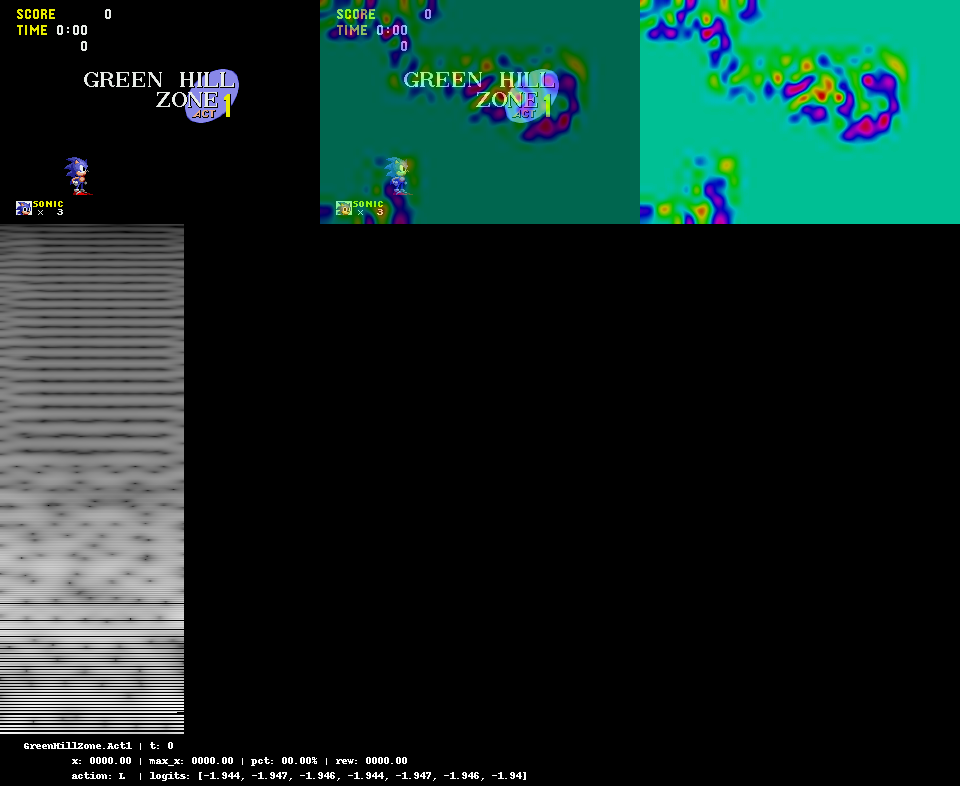

In [10]:
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size).to(device)
masks = torch.zeros(1, 1).to(device)

obs = env.reset()
i = 0
info = None
while True:
    if i >= 1:
        break
    with torch.no_grad():
        value, action, _, recurrent_hidden_states, logits = actor_critic.act(
            obs, recurrent_hidden_states, masks, deterministic=True)

    x = 0 if info is None else info[0]['x']
    max_x = 0 if info is None else info[0]['max_x']
    pct = 0 if info is None else info[0]['max_x']/info[0]['lvl_max_x']*100
    rew = 0 if info is None else info[0]['sum_r']
    t = i
    actn = action.item()
    tgt_layer = {'video': 5}
    f = gen_eval_vid_frame(
        actor_critic, env_state, x, max_x, pct, rew, t, actn, logits, obs, tgt_layer)
    print(f.shape)
    display(Image.fromarray(f, 'RGB'))
    

    # Obser reward and next obs
    obs, reward, done, info = env.step(action)
    masks.fill_(0.0 if done else 1.0)
    
    if done:
        print(f"max_x {info[0]['max_x']}, stage len {info[0]['screen_x_end']}")
        break
    i += 1